
## Enunciado

> Considere la información del proyecto cuya información aparece en la tabla adjunta:
> 1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?
> 2. Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?
> 3. ¿Se encuentran nivelados los recursos consumidos por este proyecto antes de reducir su duración a 18 semanas? De no ser así proceda a su nivelación (analice únicamente dos actividades).
> 4. Si su empresa sólo puede destinar a 6 personas a este proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados tras la nivelación? Reprográmelo si fuera necesario de modo que se cumpla esta restricción.

In [1]:
%%capture
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown


"""
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"


if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files
"""
# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph
%cd ~/temp



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, varianza,  cur,  recursos, duracion_tope
     ('A',       '---  ',      2,        1,     -100,     2,         1        ),
     ('B',       '---  ',      4,        1,       30,     2,         2        ),
     ('C',       'B    ',      1,        1,   np.inf,     2,         1        ),
     ('D',       'A    ',      3,        1,       50,     2,         1        ),
     ('E',       'B,D  ',      7,        1,       20,     2,         4        ),
     ('F',       'B,C,D  ',      4,        1,       10,     2,         2        ),
     ('G',       '---  ',      1,        2,      100,     4,         1        ),
     ('H',       'G    ',     11,        2,       10,     2,         8        ),
     ('I',       'E,F,H',      2,        1,       50,     2,         1        ),
     ('J',       'E,F,H',      8,        1,        5,     2,         7        ),
] ,columns=['activity', 'predecessor', 'duration', 'variance', 'ucr', 'resources', 'cap_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,variance,ucr,resources,cap_duration
activity,,,,,,
A,---,2,1,-100.0,2,1
B,---,4,1,30.0,2,2
C,B,1,1,inf,2,1
D,A,3,1,50.0,2,1
E,"B,D",7,1,20.0,2,4
F,"B,C,D",4,1,10.0,2,2
G,---,1,2,100.0,4,1
H,G,11,2,10.0,2,8
I,"E,F,H",2,1,50.0,2,1


## Solución
### Apartado 1

> ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?




#### Duración media del proyecto

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

In [3]:
from pmule import PredecessorTable, ProjectGraph

In [4]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
proyecto = prelaciones.create_project()

##### Grafo PERT con numeración de nodos

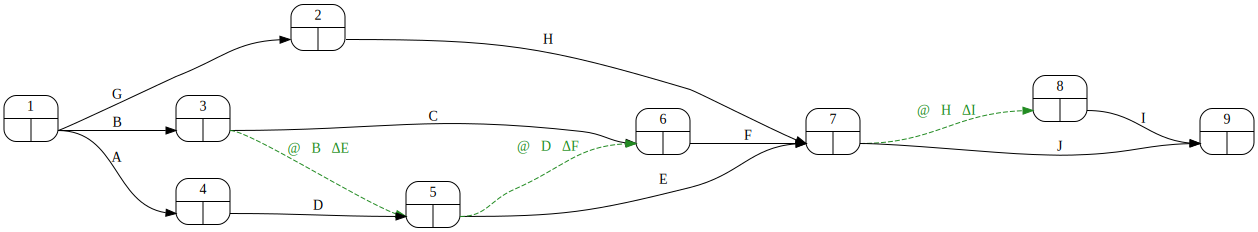

In [5]:
proyecto.pert(ranksep=1.5)

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,1.0,4.0,2.0,,,,,,0.0
2,,,,,,,11.0,,,1.0
3,,,,,0.0,1.0,,,,4.0
4,,,,,3.0,,,,,2.0
5,,,,,,0.0,7.0,,,5.0
6,,,,,,,4.0,,,5.0
7,,,,,,,,0.0,8.0,12.0
8,,,,,,,,,2.0,12.0
9,,,,,,,,,,20.0
late,0.0,1.0,5.0,2.0,5.0,8.0,12.0,18.0,20.0,


In [7]:
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,1,1
3,4,5
4,2,2
5,5,5
6,5,8
7,12,12
8,12,18
9,20,20


##### Duración media del proyecto

La duración media del proyecto es:

In [8]:
duracion_media_proyecto = proyecto.duration(durations=datos_proyecto['duration'])
duracion_media_proyecto

20

#### Varianza de la duración del proyecto
Para determinar la varianza de la duración del proyecto es necesario determinar la varianza de cada rama del camino crítico.

##### Holguras

In [9]:
resultados_pert['activities']

,H_total
@∇B⤑ΔE,1
@∇D⤑ΔF,3
@∇H⤑ΔI,6
A,0
B,1
C,3
D,0
E,0
F,3
G,0


##### Camino crítico

In [10]:
camino_critico = proyecto.critical_path(durations=datos_proyecto['duration'])
camino_critico

{'Route_1': ['G', 'H', 'J'], 'Route_9': ['A', 'D', 'E', 'J']}

##### Grafo PERT con indicación del camino crítico

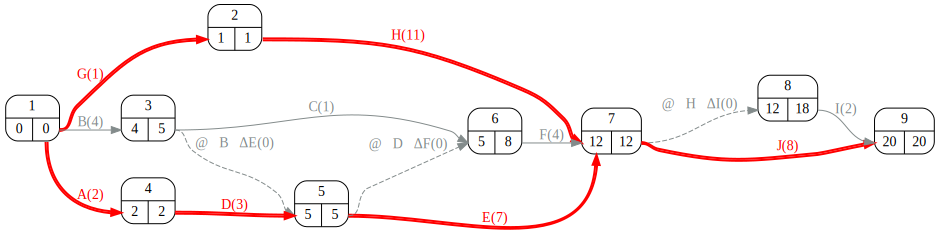

In [11]:
proyecto.pert(durations=datos_proyecto['duration'])

##### Varianza de cada rama

A la vista del grafo PERT el camino crítico se compone de 2 ramas.

In [12]:
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])
desviacion_proyecto

Variance path: Route_1 : 5
Variance path: Route_9 : 4
Project duration variance: 5
Project duration standard deviation: 2.23606797749979


2.23606797749979

#### Probabilidad de terminar entre 17 y 19 periodos

In [13]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_19 = norm.cdf(19, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_17 = norm.cdf(17, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_17_y_19 = probabilidad_de_terminar_antes_de_19 - probabilidad_de_terminar_antes_de_17
probabilidad_de_terminar_entre_17_y_19 * 100

23.75041755697886

### Apartado 2
> Como la probabilidad antes calculada le parece baja, reduzca, con mínimo coste la duración media del proyecto a 18 semanas.
¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Y la probabilidad de terminar entre 19 y 17 semanas?



In [14]:
datos_proyecto['duration']

,duration
activity,
A,2
B,4
C,1
D,3
E,7
F,4
G,1
H,11
I,2


In [15]:
proyecto.path_matrix(dummies=False) @ datos_proyecto['duration']

,0
Route_1,20
Route_2,14
Route_3,17
Route_4,11
Route_5,19
Route_6,13
Route_7,16
Route_8,10
Route_9,20
Route_10,14


In [16]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)
ackoff

D shape (10,)
Path matrix shape (12, 10)


Step: 0,	 Best option: ['A', 'J'], 	 Cost: -95.0, 	 Critical paths: ['Route_1', 'Route_9']
Step: 1,	 Best option: ['H'], 	 Cost: 10.0, 	 Critical paths: ['Route_1']





,A,B,C,D,E,F,G,H,I,J,0,1,2
Route_1,,,,,,,100.0,10.0,,5.0,20.0,19.0,18.0
Route_2,,,,,,,100.0,10.0,50.0,,14.0,14.0,13.0
Route_3,,30.0,inf,,,10.0,,,,5.0,17.0,16.0,16.0
Route_4,,30.0,inf,,,10.0,,,50.0,,11.0,11.0,11.0
Route_5,,30.0,,,20.0,,,,,5.0,19.0,18.0,18.0
Route_6,,30.0,,,20.0,,,,50.0,,13.0,13.0,13.0
Route_7,,30.0,,,,10.0,,,,5.0,16.0,15.0,15.0
Route_8,,30.0,,,,10.0,,,50.0,,10.0,10.0,10.0
Route_9,-100.0,,,50.0,20.0,,,,,5.0,20.0,18.0,18.0
Route_10,-100.0,,,50.0,20.0,,,,50.0,,14.0,13.0,13.0


#### Probabilidad de terminar antes de 18 periodos
Al ser 18 el valor de la media de la duración, la probabilidad pedida es del 50%.

#### Probabilidad de terminar entre 19 y 17 semanas

##### Duración media del proyecto

Nótese como al haber reducido la duración del proyecto la duración media a utilizar en el cálculo de la probabilidad es la nueva duración recortada de 18 periodos.

In [17]:
duracion_media_proyecto = proyecto.duration(duration)
duracion_media_proyecto

18

##### Varianza de la duración del proyecto

Al proyecto le ha surgido una nueva rama, que llamaremos rama 3. Debemos calcular la varianza de esta nueva rama y actualizar el valor de la varianza del proyecto si fuera menor que la de esta rama.

In [18]:
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])
desviacion_proyecto

Variance path: Route_1 : 5
Variance path: Route_9 : 4
Project duration variance: 5
Project duration standard deviation: 2.23606797749979


2.23606797749979

En este caso la varianza de la nueva rama es inferior a la ya calculada para el proyecto.

##### Cálculo de la probabilidad

In [19]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_19 = norm.cdf(19, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_17 = norm.cdf(17, loc=duracion_media_proyecto, scale=desviacion_proyecto)

probabilidad_de_terminar_entre_17_y_19 = probabilidad_de_terminar_antes_de_19 - probabilidad_de_terminar_antes_de_17
probabilidad_de_terminar_entre_17_y_19 * 100

34.527915398142305

### Apartado 3
> ¿Se encuentran nivelados los recursos consumidos por este proyecto antes de reducir su duración a 18 semanas? De no ser así proceda a su nivelación (analice únicamente dos actividades).

#### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [20]:
proyecto_nivelacion = proyecto.copy()
_, dibujo = proyecto_nivelacion.gantt_cargas(datos_proyecto, 'duration', 'resources')
TexFragment(dibujo).run_latex()

Suma de cuadrados: 456 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2,2,,,,,,,,,,,,,,,,,,,0.000000
B,2,2,2,2,,,,,,,,,,,,,,,,,1.000000
C,,,,,2,,,,,,,,,,,,,,,,3.000000
D,,,2,2,2,,,,,,,,,,,,,,,,0.000000
E,,,,,,2,2,2,2,2,2,2,,,,,,,,,0.000000
F,,,,,,2,2,2,2,,,,,,,,,,,,3.000000
G,4,,,,,,,,,,,,,,,,,,,,0.000000
H,,2,2,2,2,2,2,2,2,2,2,2,,,,,,,,,0.000000
I,,,,,,,,,,,,,2,2,,,,,,,6.000000
J,,,,,,,,,,,,,2,2,2,2,2,2,2,2,0.000000


La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

Se comienza buscando la actividad no crítica con su final más temprano más próximo al final del proyecto.

In [21]:
(proyecto.calendar(datos_proyecto['duration'])
 .loc[:, ['fin_mas_temprano', 'H_total']]
 .sort_values(by='fin_mas_temprano', ascending=False)
 .query('H_total > 0')
)

,fin_mas_temprano,H_total
activity,,
I,14,6
F,9,3
C,5,3
B,4,1


Esta primera actividad en la que actuar es al I. Puede apreciarse también directamente en el diagrama de Gantt anterior.

#### Nivelación de los recursos

##### Primera actividad: I

In [22]:
duracion_y_recursos = datos_proyecto.loc[:, ['duration', 'resources']]
suma_de_cuadrados = proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos, 'duration', 'resources', 'I')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 456 

Desplazamiento: 1
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,2.000000,2.000000,,,,,,5.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,2.000000,2.000000,,,,,4.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,2.000000,2.000000,,,,3.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 4
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,2.000000,2.000000,,,2.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 5
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,2.000000,2.000000,,1.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 6
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,3.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,3.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,2.000000,2.000000,0.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


,Suma_de_cuadrados
0,456
1,456
2,456
3,456
4,456
5,456
6,456


La actividad *slide_I* representa el desplazamiento de las actividad I.

Desplazar la actividad I no conlleva ninguna mejora en la nivelación.

##### Segunda actividad: F

Se prosigue desplazando la actividad I otro periodo más al disponer de holgura para una actuación adicional.

In [23]:
suma_de_cuadrados = proyecto_nivelacion.evaluar_rango_de_desplazamientos(duracion_y_recursos, 'duration', 'resources', 'F')
suma_de_cuadrados

Sin desplazar:
Suma de cuadrados: 456 

Desplazamiento: 1
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,2.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,2.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 2
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,1.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,1.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,1.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Desplazamiento: 3
Suma de cuadrados: 456.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,0.000000
C,,,,,2.000000,,,,,,,,,,,,,,,,0.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


,Suma_de_cuadrados
0,456
1,456
2,456
3,456


Desplazar la actividad F tampoco conlleva ninguna mejora en la nivelación. Sin embargo en el enunciado nos indican que sólo analicemos las primeras dos actividades y por tanto no se continua nivelando.

### Apartado 4
> Si su empresa sólo puede destinar a 6 personas a este proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados tras la nivelación? Reprogramelo si fuera necesario de modo que se cumpla esta restricción.


In [24]:
proyecto_asignacion = proyecto_nivelacion.copy()
proyecto_asignacion.gantt(duracion_y_recursos, 'duration', 'resources', total='fila', holguras=True)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2,2,,,,,,,,,,,,,,,,,,,0.000000
B,2,2,2,2,,,,,,,,,,,,,,,,,1.000000
C,,,,,2,,,,,,,,,,,,,,,,3.000000
D,,,2,2,2,,,,,,,,,,,,,,,,0.000000
E,,,,,,2,2,2,2,2,2,2,,,,,,,,,0.000000
F,,,,,,2,2,2,2,,,,,,,,,,,,3.000000
G,4,,,,,,,,,,,,,,,,,,,,0.000000
H,,2,2,2,2,2,2,2,2,2,2,2,,,,,,,,,0.000000
I,,,,,,,,,,,,,2,2,,,,,,,6.000000
J,,,,,,,,,,,,,2,2,2,2,2,2,2,2,0.000000


El proyecto requiere más de 6 personas en el primer periodo aplicar dos iteraciones del algoritmo de nivelación. Es necesario aplicar el algorimo de asignación. El primer periodo conflictivo es el 1.

##### Asignación primer periodo

En el primer periodo la actividad B debe ser retrasada un periodo.

In [25]:
duracion_y_recursos = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', B = 1, mostrar='recursos')

Suma de cuadrados: 448.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,H_total
A,2.000000,2.000000,,,,,,,,,,,,,,,,,,,0.000000
B,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
C,,,,,,2.000000,,,,,,,,,,,,,,,2.000000
D,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
F,,,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,2.000000
G,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
H,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,2.000000,2.000000,,,,,,,6.000000
J,,,,,,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000


Tras esta actuación el proyecto ya es compatible con la restricción impuesta en los recursos.